In [1]:
# Installation des packages Python nécessaires en utilisant pip

!pip install Pandas pillow tensorflow pyspark pyarrow


In [2]:
# Import des librairies

import pandas as pd
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import io
import os
import tensorflow as tf
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras import Model
from pyspark.sql.functions import col, pandas_udf, PandasUDFType, element_at, split
from pyspark.sql import SparkSession
from pyspark.ml.feature import PCA
from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.sql.functions import udf
from pyspark.sql.types import StructType, StructField, ArrayType, FloatType, StringType




2023-10-05 11:19:54.566158: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
# Obtenir le répertoire de travail actuel
PATH = os.getcwd()

# Définir les chemins vers les répertoires de données et de résultats en fonction du répertoire actuel
PATH_Data = PATH + '/data/Test1'
PATH_Result = PATH + '/data/Results'

# Afficher les chemins
print('PATH:        ' + PATH + '\nPATH_Data:   ' + PATH_Data + '\nPATH_Result: ' + PATH_Result)


PATH:        /Users/azizi/Projet 8
PATH_Data:   /Users/azizi/Projet 8/data/Test1
PATH_Result: /Users/azizi/Projet 8/data/Results


In [4]:
# Création d'une session Spark 
spark = (SparkSession
         .builder
         .appName('P8')  # Nom de l'application Spark
         .master('local')  # Mode d'exécution local
         .config("spark.sql.parquet.writeLegacyFormat", 'true')  # Configuration pour écrire en format Parquet legacy
         .getOrCreate()  # Obtenir ou créer une session Spark
)


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/10/05 11:20:12 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


<u>Nous créons également la variable "**sc**" qui est un **SparkContext** issue de la variable **spark**</u> :

In [5]:
# Obtention du contexte Spark à partir de la session Spark

sc = spark.sparkContext


In [6]:
# Affichage des informations de Spark en cours d'execution :

spark

In [7]:
# Chargement des images à partir du dossier spécifié

images = spark.read.format("binaryFile") \
  .option("pathGlobFilter", "*.jpg") \
  .option("recursiveFileLookup", "true") \
  .load(PATH_Data)


In [8]:
# Ajout d'une colonne 'label' au DataFrame 'images' en extrayant le label à partir du chemin du fichier

images = images.withColumn('label', element_at(split(images['path'], '/'), -2))

# Affichage du schéma du DataFrame 'images' et des cinq premières lignes des colonnes 'path' et 'label'

print(images.printSchema())
print(images.select('path', 'label').show(5, False))


root
 |-- path: string (nullable = true)
 |-- modificationTime: timestamp (nullable = true)
 |-- length: long (nullable = true)
 |-- content: binary (nullable = true)
 |-- label: string (nullable = true)

None


+------------------------------------------------+-----+
|path                                            |label|
+------------------------------------------------+-----+
|file:/Users/azizi/Projet 8/data/Test1/r1_235.jpg|Test1|
|file:/Users/azizi/Projet 8/data/Test1/r1_231.jpg|Test1|
|file:/Users/azizi/Projet 8/data/Test1/r1_227.jpg|Test1|
|file:/Users/azizi/Projet 8/data/Test1/r1_215.jpg|Test1|
|file:/Users/azizi/Projet 8/data/Test1/r1_223.jpg|Test1|
+------------------------------------------------+-----+
only showing top 5 rows

None


## Extraction des features à partir des Images

In [9]:
# Création d'un modèle MobileNetV2 pré-entraîné avec les poids ImageNet

model = MobileNetV2(weights='imagenet',
                    include_top=True,
                    input_shape=(224, 224, 3))


In [10]:
# Création d'un nouveau modèle en utilisant une couche intermédiaire du modèle précédent

new_model = Model(inputs=model.input,
                  outputs=model.layers[-2].output)


In [11]:
# Affichage du sommaire (summary) du nouveau modèle

new_model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[0][0]']        

In [12]:
# Diffusion (broadcast) des poids du modèle à travers Spark

broadcast_weights = sc.broadcast(new_model.get_weights())


In [13]:
def model_fn():
    """
    Fonction qui renvoie un modèle MobileNetV2 avec la couche supérieure supprimée
    et les poids pré-entraînés diffusés (broadcasted).
    """
    # Création du modèle MobileNetV2 avec les poids ImageNet et suppression de la couche supérieure
    model = MobileNetV2(weights='imagenet',
                        include_top=True,
                        input_shape=(224, 224, 3))
    
    # Définition de toutes les couches du modèle comme non entraînables
    for layer in model.layers:
        layer.trainable = False
    
    # Création d'un nouveau modèle avec la sortie de l'avant-dernière couche
    new_model = Model(inputs=model.input,
                  outputs=model.layers[-2].output)
    
    # Initialisation des poids du nouveau modèle avec les poids diffusés (broadcasted)
    new_model.set_weights(broadcast_weights.value)
    
    return new_model


In [14]:
def preprocess(content):
    """
    Prétraite les octets d'image bruts pour la prédiction.
    """
    # Ouvre l'image à partir des octets bruts, la redimensionne à [224, 224]
    img = Image.open(io.BytesIO(content)).resize([224, 224])
    
    # Convertit l'image en tableau NumPy
    arr = img_to_array(img)
    
    # Applique la prétraitement spécifique à MobileNetV2 aux données d'entrée
    return preprocess_input(arr)


In [15]:
def featurize_series(model, content_series):
    """
    Transforme une série pd.Series d'images brutes en utilisant le modèle d'entrée.
    :return: une série pd.Series de caractéristiques d'images
    """
    # Prétraite les images de la série d'entrée en utilisant la fonction preprocess
    input = np.stack(content_series.map(preprocess))
    
    # Effectue des prédictions en utilisant le modèle
    preds = model.predict(input)
    
    # Pour certaines couches, les caractéristiques de sortie seront des tenseurs multidimensionnels.
    # Nous aplatissons les tenseurs de caractéristiques en vecteurs pour un stockage plus facile
    # dans les DataFrames Spark.
    output = [p.flatten() for p in preds]
    
    # Renvoie les caractéristiques d'images sous forme de série pd.Series
    return pd.Series(output)


In [16]:
@pandas_udf('array<float>', PandasUDFType.SCALAR_ITER)
def featurize_udf(content_series_iter):
    '''
    Cette méthode est une UDF pandas Scalar Iterator qui encapsule notre fonction de caractérisation.
    Le décorateur spécifie que cette méthode renvoie une colonne Spark DataFrame de type ArrayType(FloatType).

    :param content_series_iter: Cet argument est un itérateur sur des lots de données, où chaque lot
                                est une série pandas contenant des données d'image.
    '''
    # Avec les UDF pandas Scalar Iterator, nous pouvons charger le modèle une fois et le réutiliser
    # pour plusieurs lots de données. Cela amortit les coûts liés au chargement de grands modèles.
    model = model_fn()
    for content_series in content_series_iter:
        yield featurize_series(model, content_series)


/Users/azizi/opt/anaconda3/lib/python3.9/site-packages/pyspark/sql/pandas/functions.py:399: UserWarning: In Python 3.6+ and Spark 3.0+, it is preferred to specify type hints for pandas UDF instead of specifying pandas UDF type which will be deprecated in the future releases. See SPARK-28264 for more details.
  warnings.warn(


In [17]:
# Configuration de l'option Spark SQL pour le nombre maximal d'enregistrements par lot à 1024

spark.conf.set("spark.sql.execution.arrow.maxRecordsPerBatch", "1024")


In [18]:
# Création d'un DataFrame "features_df" en répartissant les données en 20 partitions,
# en sélectionnant les colonnes "path" et "label", et en utilisant la fonction "featurize_udf" pour générer la colonne "features"

features_df = images.repartition(20).select(col("path"),
                                            col("label"),
                                            featurize_udf("content").alias("features")
                                           )


In [19]:
# Affichage du chemin vers le répertoire de résultats

print(PATH_Result)


/Users/azizi/Projet 8/data/Results


In [20]:
# Écriture des données en mode "overwrite" au format parquet dans le chemin spécifié

features_df.write.mode("overwrite").parquet(PATH_Result)


1/1 [==============================] - 1s 1s/step==============>  (19 + 1) / 20]


In [21]:
# Lecture des données au format parquet depuis le chemin spécifié en utilisant le moteur 'pyarrow'

df = pd.read_parquet(PATH_Result, engine='pyarrow')


In [22]:
# Afficher les premières lignes du DataFrame pour examiner les données

df.head()


,path,label,features
0,file:/Users/azizi/Projet 8/data/Test1/r_256_10...,Test1,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0380081, 1.2970654..."
1,file:/Users/azizi/Projet 8/data/Test1/r1_235.jpg,Test1,"[0.0, 0.6891457, 0.0, 0.0, 0.0, 0.12752676, 1...."
2,file:/Users/azizi/Projet 8/data/Test1/r_266_10...,Test1,"[0.024694063, 0.0, 0.0, 0.0, 0.0, 0.3731625, 2..."
3,file:/Users/azizi/Projet 8/data/Test1/r_231_10...,Test1,"[0.04762171, 0.0, 0.0, 0.0, 0.0, 0.8979101, 0...."
4,file:/Users/azizi/Projet 8/data/Test1/r2_111_1...,Test1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.46710715, 0.153004..."


In [23]:
# Obtenir la forme (shape) de la colonne 'features' de la première ligne du DataFrame

df.loc[0, 'features'].shape


(1280,)

## Réduction de Dimension avec l'Analyse en Composantes Principales (PCA)

23/10/05 11:22:02 WARN TaskSetManager: Stage 4 contains a task of very large size (4204 KiB). The maximum recommended task size is 1000 KiB.
23/10/05 11:22:04 WARN TaskSetManager: Stage 5 contains a task of very large size (4204 KiB). The maximum recommended task size is 1000 KiB.
23/10/05 11:22:05 WARN TaskSetManager: Stage 6 contains a task of very large size (4204 KiB). The maximum recommended task size is 1000 KiB.
23/10/05 11:22:07 WARN TaskSetManager: Stage 7 contains a task of very large size (4204 KiB). The maximum recommended task size is 1000 KiB.
23/10/05 11:22:07 WARN TaskSetManager: Stage 8 contains a task of very large size (4204 KiB). The maximum recommended task size is 1000 KiB.
23/10/05 11:22:11 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
23/10/05 11:22:12 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK
23/10/05 11:22:21 WARN TaskSetManager: Stage 9 contains a task of very large 

+--------------------+-----+--------------------+--------------------+--------------------+
|                path|label|            features|      dense_features|        pca_features|
+--------------------+-----+--------------------+--------------------+--------------------+
|file:/Users/azizi...|Test1|[0.0, 0.0, 0.0, 0...|[0.0,0.0,0.0,0.0,...|[5.58628644349060...|
|file:/Users/azizi...|Test1|[0.0, 0.6891457, ...|[0.0,0.6891456842...|[0.63740099118484...|
|file:/Users/azizi...|Test1|[0.024694063, 0.0...|[0.02469406276941...|[2.26784193585506...|
|file:/Users/azizi...|Test1|[0.04762171, 0.0,...|[0.04762170836329...|[9.23635951193193...|
|file:/Users/azizi...|Test1|[0.0, 0.0, 0.0, 0...|[0.0,0.0,0.0,0.0,...|[7.95185687702944...|
|file:/Users/azizi...|Test1|[0.91579735, 0.06...|[0.91579735279083...|[-9.8954378599870...|
|file:/Users/azizi...|Test1|[0.0, 0.0, 0.0, 0...|[0.0,0.0,0.0,0.0,...|[5.69788212801388...|
|file:/Users/azizi...|Test1|[0.40652597, 0.22...|[0.40652596950531...|[-10.19806

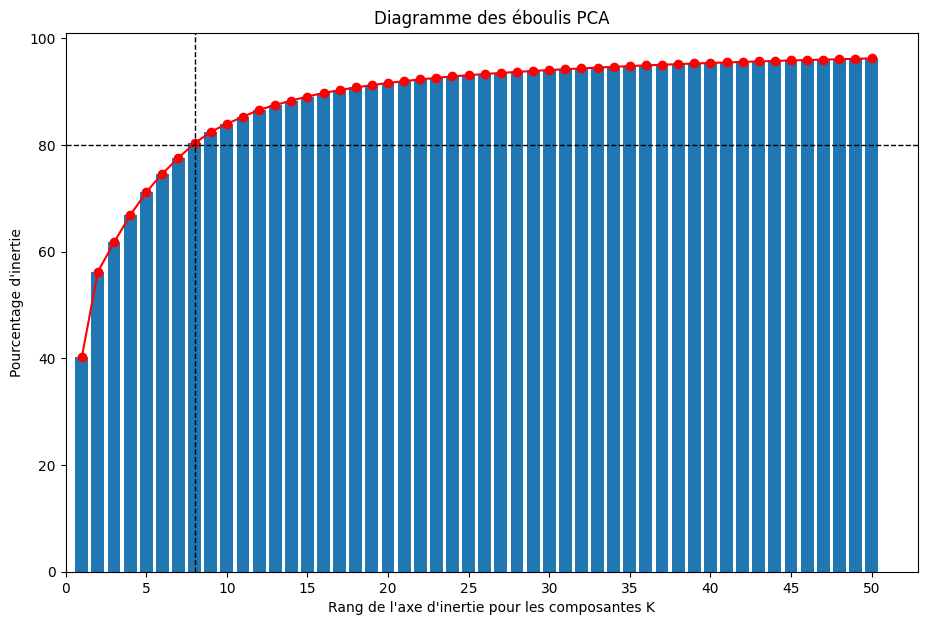

________________________________________________________________
80% de la variance totale est expliquée par les 8 premiers axes
________________________________________________________________


In [24]:
# Chargement des données prétraitées dans un DataFrame Spark
# Assurez-vous que le champ 'features' est une liste Python, pas un tableau numpy
df['features'] = df['features'].apply(lambda x: x.tolist())
schema = StructType([
    StructField("path", StringType(), True),
    StructField("label", StringType(), True),
    StructField("features", ArrayType(FloatType()), True)
])
spark_df = spark.createDataFrame(df, schema=schema)

# Convertir la liste 'features' en vecteur dense
array_to_vector_udf = udf(lambda l: Vectors.dense(l), VectorUDT())
vectorized_df = spark_df.withColumn('dense_features', array_to_vector_udf(spark_df['features']))

# Spécifier le nombre de composantes principales souhaité
num_components = 50

# Effectuer la PCA 
pca = PCA(k=num_components, inputCol="dense_features", outputCol="pca_features")
pca_model = pca.fit(vectorized_df)
pca_result = pca_model.transform(vectorized_df)

# Afficher les premières lignes du résultat
pca_result.show()

# accéder aux composantes principales
pca_components = pca_model.pc.toArray()
print("Composantes principales :")
print(pca_components)

# Fonction pour afficher le diagramme des éboulis PCA
def display_pca_scree(pca_model):
    scree_data = (pca_model.explainedVariance * 100).cumsum()
    plt.figure(figsize=(11, 7))
    plt.bar(np.arange(len(scree_data)) + 1, scree_data)
    plt.plot(np.arange(len(scree_data)) + 1, scree_data, c="red", marker='o')
    plt.axhline(y=80, linestyle="--", color="black", linewidth=1)

    limit = 80
    valid_idx = np.where(scree_data >= limit)[0]
    min_planes = valid_idx[scree_data[valid_idx].argmin()] + 1
    plt.axvline(x=min_planes, linestyle="--", color="black", linewidth=1)

    plt.xlabel("Rang de l'axe d'inertie pour les composantes K")
    plt.xticks(np.arange(0, 55, 5))
    plt.xlim(left=0)
    plt.ylabel("Pourcentage d'inertie")
    plt.title("Diagramme des éboulis PCA")
    plt.show()
    print("_"*64)
    print("{}% de la variance totale est expliquée par les {} premiers axes".format(limit, min_planes))
    print("_"*64)

display_pca_scree(pca_model)

# Transformation inverse (de Vectors à Arrays)
vector_to_array_udf = udf(lambda v: v.toArray().tolist(), ArrayType(FloatType()))
data_final = pca_result.withColumn('features', vector_to_array_udf('pca_features'))

In [25]:
# Enregistrement des données traitées au format "parquet"

data_final.write.mode('overwrite').parquet(PATH_Result)


23/10/05 11:22:23 WARN TaskSetManager: Stage 10 contains a task of very large size (4204 KiB). The maximum recommended task size is 1000 KiB.


In [26]:
# Chargement des données à partir d'un fichier au format Parquet en utilisant le moteur 'pyarrow'
df = pd.read_parquet(PATH_Result, engine='pyarrow')

# Affichage du DataFrame résultant
df


,path,label,features,dense_features,pca_features
0,file:/Users/azizi/Projet 8/data/Test1/r_256_10...,Test1,"[5.5862865, -3.834116, 4.467784, 2.257022, -2....","{'type': 1, 'size': None, 'indices': None, 'va...","{'type': 1, 'size': None, 'indices': None, 'va..."
1,file:/Users/azizi/Projet 8/data/Test1/r1_235.jpg,Test1,"[0.637401, -1.6719651, -2.847304, 4.8106623, -...","{'type': 1, 'size': None, 'indices': None, 'va...","{'type': 1, 'size': None, 'indices': None, 'va..."
2,file:/Users/azizi/Projet 8/data/Test1/r_266_10...,Test1,"[2.267842, -3.1018393, 6.7548366, 1.3559854, -...","{'type': 1, 'size': None, 'indices': None, 'va...","{'type': 1, 'size': None, 'indices': None, 'va..."
3,file:/Users/azizi/Projet 8/data/Test1/r_231_10...,Test1,"[9.23636, -6.303132, 0.2679764, 2.205414, 1.48...","{'type': 1, 'size': None, 'indices': None, 'va...","{'type': 1, 'size': None, 'indices': None, 'va..."
4,file:/Users/azizi/Projet 8/data/Test1/r2_111_1...,Test1,"[7.951857, -9.071614, -1.8409573, -5.486841, -...","{'type': 1, 'size': None, 'indices': None, 'va...","{'type': 1, 'size': None, 'indices': None, 'va..."
...,...,...,...,...,...
366,file:/Users/azizi/Projet 8/data/Test1/70_100.jpg,Test1,"[-12.85657, -1.2948906, 2.964324, -3.572811, -...","{'type': 1, 'size': None, 'indices': None, 'va...","{'type': 1, 'size': None, 'indices': None, 'va..."
367,file:/Users/azizi/Projet 8/data/Test1/71_100.jpg,Test1,"[-13.075116, -1.3995321, 2.3934236, -3.7265906...","{'type': 1, 'size': None, 'indices': None, 'va...","{'type': 1, 'size': None, 'indices': None, 'va..."
368,file:/Users/azizi/Projet 8/data/Test1/24_100.jpg,Test1,"[1.4409068, 9.796061, 0.08536889, -4.4668827, ...","{'type': 1, 'size': None, 'indices': None, 'va...","{'type': 1, 'size': None, 'indices': None, 'va..."
369,file:/Users/azizi/Projet 8/data/Test1/285_100.jpg,Test1,"[6.0759892, 9.954883, -2.3220725, -2.4380043, ...","{'type': 1, 'size': None, 'indices': None, 'va...","{'type': 1, 'size': None, 'indices': None, 'va..."


## Fermeture de la session Spark

In [27]:
# Fermeture de la session Spark

spark.stop()